# AlphaCapture Strategy

This project involves the collection, analysis, and modeling of financial data to develop a trading strategy using machine learning techniques. The main objectives are to gather historical stock data, engineer features, generate trading signals using a machine learning model, backtest the strategy, evaluate performance metrics, optimize the model, and implement risk management techniques.

## Requirements

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

## Data Collection

The Data Collection section of the project uses yfinance to extract the data of the top 6 companies by market cap in the S&P 500. In this case, we will use MSFT: Microsoft, NVDA: Nvidia, AAPL: Apple, AMZN: Amazon, META: Meta Platforms, GOOGL: Alphabet (Google).

The data will be extracted from the previous 4 years and we will use the adjusted close price which takes into account the closing price after adjustments for all applicable splits and dividend distributions. We will calculate the daily returns as well.

In [8]:
tickers = ['MSFT', 'NVDA', 'AAPL', 'AMZN', 'META', 'GOOGL']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Adj Close']
returns = data.pct_change()

[*********************100%%**********************]  6 of 6 completed


Now that we have the data on hand, we can go ahead and calculate a couple technical indicators. Technical indicators are crucial for our purposes as they are used to analyze past market data to forecast future price movements.

1. 20-day Simple Moving Average (SMA)

The 20-day SMA calculates the average price of a stock over the past 20 days. It helps smooth out short-term fluctuations and highlight longer-term trends. Investors often use the 20-day SMA to identify short-term trends and potential buy or sell signals. When the stock price crosses above the 20-day SMA, it may be considered a bullish signal, and when it crosses below, it may be considered bearish. 

2. 50-day Simple Moving Average (SMA)

The 50-day SMA calculates the average price over the past 50 days. It is a more stable indicator compared to the 20-day SMA and is used to identify medium-term trends. The 50-day SMA is commonly used to confirm trends. A stock price consistently above the 50-day SMA is considered to be in an uptrend, while consistently below indicates a downtrend.

3. 20-day Exponential Moving Average (EMA) 

The 20-day EMA gives more weight to recent prices compared to the SMA, making it more responsive to new information. It is calculated using an exponential smoothing factor. The 20-day EMA is used to identify short-term trends and potential reversals. It reacts more quickly to price changes than the SMA, providing more timely signals.

4. 20-day Momentum

Momentum measures the rate of change of a stock's price over a specified period (20 days in this case). It is calculated as the difference between the current price and the price 20 days ago. Momentum is used to identify the strength and speed of a price movement. Positive momentum indicates a strong upward movement, while negative momentum indicates a strong downward movement. It helpful for identifying potential trend continuations or reversals.

In [9]:
for ticker in tickers:
    data[f'{ticker}_SMA_20'] = data[ticker].rolling(window=20).mean()
    data[f'{ticker}_SMA_50'] = data[ticker].rolling(window=50).mean()
    data[f'{ticker}_EMA_20'] = data[ticker].ewm(span=20, adjust=False).mean()
    data[f'{ticker}_Momentum'] = returns[ticker].rolling(window=20).mean()

Once we have all our indicators, we can merge them into a single df we'll define as indicators.

In [10]:
indicators = pd.concat([data, returns.rename(columns={ticker: f'{ticker}_Returns' for ticker in tickers})], axis=1)
indicators.tail()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,MSFT_SMA_20,MSFT_SMA_50,MSFT_EMA_20,MSFT_Momentum,...,GOOGL_SMA_20,GOOGL_SMA_50,GOOGL_EMA_20,GOOGL_Momentum,AAPL_Returns,AMZN_Returns,GOOGL_Returns,META_Returns,MSFT_Returns,NVDA_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-22,193.091385,153.419998,141.490005,353.015472,373.215393,48.827713,372.168239,358.389024,369.997947,-0.000333,...,134.540501,133.442201,135.404904,0.001863,-0.005547,-0.002730,0.007620,-0.001977,0.002784,-0.003266
2023-12-26,192.542816,153.410004,141.520004,354.453918,373.295135,49.276688,371.971460,359.337433,370.311965,-0.000479,...,134.796001,133.525401,135.987295,0.001976,-0.002841,-0.000065,0.000212,0.004075,0.000214,0.009195
2023-12-27,192.642548,153.339996,140.369995,357.450714,372.707275,49.414680,371.541531,360.176442,370.540090,-0.001098,...,134.954501,133.550800,136.404695,0.001280,0.000518,-0.000456,-0.008126,0.008455,-0.001575,0.002800
2023-12-28,193.071426,153.380005,140.229996,357.940216,373.912842,49.519676,371.363681,361.051095,370.861304,-0.000433,...,135.216501,133.561000,136.769009,0.002036,0.002226,0.000261,-0.000997,0.001369,0.003235,0.002125
2023-12-29,192.024185,151.940002,139.690002,353.584839,374.670074,49.519676,371.220703,361.979673,371.224044,-0.000340,...,135.574501,133.595600,137.047199,0.002755,-0.005424,-0.009388,-0.003851,-0.012168,0.002025,0.000000


## Feature Engineering

We could proceed with the indicators we defined above, but there are other indicators that could be useful for this project. The next 3 indicators we'll calculate are based on volatility and volume data.

In [11]:
volume_data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Volume']

[*********************100%%**********************]  6 of 6 completed


Additional Indicators:

1. Volatility (20-day)

Volatility is a statistical measure of the dispersion of returns. It is calculated as the rolling standard deviation of daily returns over a 20-day window. Higher volatility indicates higher risk and potential for larger price swings. It's helpful in assessing the risk associated with a particular stock.

2. Volume

Volume data reflects the trading activity for a stock. It shows the total number of shares traded over a specific period. Volume spikes can indicate strong investor interest and potential price movements. It is used to confirm trends and identify potential reversals. High volume during a price move suggests strong momentum behind the move.

3. Volume (20-day SMA)

The 20-day SMA of volume smooths out short-term fluctuations and highlights longer-term trends in trading activity. Comparing the current volume to its SMA can help identify unusual trading activity, which might precede significant price moves. For example, if the current volume is significantly higher than the SMA, it could indicate strong buying or selling pressure.

In [12]:
for ticker in tickers:
    indicators[f'{ticker}_Volatility'] = returns[ticker].rolling(window=20).std()
    indicators[f'{ticker}_Volume'] = volume_data[ticker]
    indicators[f'{ticker}_Volume_SMA_20'] = volume_data[ticker].rolling(window=20).mean()
indicators.tail()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,MSFT_SMA_20,MSFT_SMA_50,MSFT_EMA_20,MSFT_Momentum,...,AAPL_Volume_SMA_20,AMZN_Volatility,AMZN_Volume,AMZN_Volume_SMA_20,META_Volatility,META_Volume,META_Volume_SMA_20,GOOGL_Volatility,GOOGL_Volume,GOOGL_Volume_SMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-22,193.091385,153.419998,141.490005,353.015472,373.215393,48.827713,372.168239,358.389024,369.997947,-0.000333,...,53993285.0,0.011908,29480100,50533985.0,0.016090,11764200,17521030.0,0.017055,26514600,32692160.0
2023-12-26,192.542816,153.410004,141.520004,354.453918,373.295135,49.276688,371.971460,359.337433,370.311965,-0.000479,...,53411620.0,0.011871,25067200,49099225.0,0.015809,9898600,17231735.0,0.017035,16780300,32359350.0
2023-12-27,192.642548,153.339996,140.369995,357.450714,372.707275,49.414680,371.541531,360.176442,370.540090,-0.001098,...,53895235.0,0.011782,31434700,48535375.0,0.015697,13207900,17260270.0,0.017155,19628600,32404280.0
2023-12-28,193.071426,153.380005,140.229996,357.940216,373.912842,49.519676,371.363681,361.051095,370.861304,-0.000433,...,53447020.0,0.011678,27057000,47857680.0,0.014758,11798800,17048985.0,0.016675,16045700,32008205.0
2023-12-29,192.024185,151.940002,139.690002,353.584839,374.670074,49.519676,371.220703,361.979673,371.224044,-0.000340,...,53138740.0,0.011946,39789000,46556430.0,0.014566,14980500,16640690.0,0.016054,18727200,30995150.0


## Machine Learning for Signal Generation

The next step is the machine learning (ML) stage to generate trading signals.

To prepare the data, the first thing we need to do is drop the returns. These returns columns need to be dropped because they will be used as target variables rather than features. Including them as features would lead to data leakage, where the model might unfairly learn from future data points, thus invalidating the model's predictions. Then we'll create a binary target variable where 1 indicates a positive return and 0 indicates a negative return. This binary classification will help in predicting whether the stock's return will be positive or negative. The last thing is checking for any missing values in the features and drop rows with NaN values to ensure our dataset is clean and ready for training.

In [13]:
features = indicators.drop(columns=['MSFT_Returns', 'NVDA_Returns', 'AAPL_Returns', 'AMZN_Returns', 'META_Returns', 'GOOGL_Returns'])
target = (returns > 0).astype(int)  # binary target: 1 if return is positive, else 0

print(features.isnull().sum()) # check for missing values
features = features.dropna()
target = target.reindex(features.index)

Ticker
AAPL                    0
AMZN                    0
GOOGL                   0
META                    0
MSFT                    0
NVDA                    0
MSFT_SMA_20            19
MSFT_SMA_50            49
MSFT_EMA_20             0
MSFT_Momentum          20
NVDA_SMA_20            19
NVDA_SMA_50            49
NVDA_EMA_20             0
NVDA_Momentum          20
AAPL_SMA_20            19
AAPL_SMA_50            49
AAPL_EMA_20             0
AAPL_Momentum          20
AMZN_SMA_20            19
AMZN_SMA_50            49
AMZN_EMA_20             0
AMZN_Momentum          20
META_SMA_20            19
META_SMA_50            49
META_EMA_20             0
META_Momentum          20
GOOGL_SMA_20           19
GOOGL_SMA_50           49
GOOGL_EMA_20            0
GOOGL_Momentum         20
MSFT_Volatility        20
MSFT_Volume             0
MSFT_Volume_SMA_20     19
NVDA_Volatility        20
NVDA_Volume             0
NVDA_Volume_SMA_20     19
AAPL_Volatility        20
AAPL_Volume             0
AAPL_

Next we'll split the data into training and testing sets using an 80/20 split. The shuffle=False parameter ensures that the splitting does not shuffle the data, maintaining the temporal order which is crucial for time series data. This method ensures that the model is trained on past data and tested on future data, simulating real-world conditions.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

Once we have our split we can train our RandomForestClassifier. We'll initialize and train a RandomForestClassifier with 100 trees and a random state for reproducibility. The model is trained using the training dataset. Random forests are robust classifiers that combine the predictions of multiple decision trees to improve accuracy and control overfitting.


In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

After training the model, we use it to predict the trading signals (buy/sell decisions) on the test dataset. These predictions are the model's attempt to classify whether the return for the next period will be positive or negative.

In [16]:
predictions = model.predict(X_test)

After the predicitions, we'll use a classification report to evaluate the model's performance.

In [17]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.55      0.92      0.69       104
           1       0.45      0.05      0.09       106
           2       0.59      0.60      0.59       104
           3       0.54      0.36      0.43       104
           4       0.58      0.68      0.63       108
           5       0.56      0.75      0.64       105

   micro avg       0.57      0.56      0.56       631
   macro avg       0.55      0.56      0.51       631
weighted avg       0.55      0.56      0.51       631
 samples avg       0.54      0.48      0.47       631



/Users/euge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/euge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model Evaluation Summary

The classification report provides a detailed evaluation of the machine learning model's performance across different classes. Below is a summary of the key metrics and their interpretations.

#### Classes and Metrics
- **Classes**:
  - **Class 0**: MSFT (Microsoft)
  - **Class 1**: NVDA (Nvidia)
  - **Class 2**: AAPL (Apple)
  - **Class 3**: AMZN (Amazon)
  - **Class 4**: META (Meta Platforms)
  - **Class 5**: GOOGL (Alphabet, Google)
- **Metrics**:
  - **Precision**: The accuracy of positive predictions.
  - **Recall**: The ability to capture all actual positive instances.
  - **F1-Score**: The harmonic mean of precision and recall.
  - **Support**: The number of actual instances in each class.

#### Performance by Class
- **Class 0 (MSFT)**:
  - Precision: 0.55
  - Recall: 0.92
  - F1-Score: 0.69
  - Support: 104
  
  High recall indicates that the model successfully identifies 92% of all actual positive instances for Microsoft. However, the precision of 55% suggests a significant number of false positives. The model is good at capturing most true positives but lacks accuracy in its predictions.

- **Class 1 (NVDA)**:
  - Precision: 0.45
  - Recall: 0.05
  - F1-Score: 0.09
  - Support: 106
  
  The model has very low recall for Nvidia, capturing only 5% of actual positives. The precision is also low at 45%. This indicates that the model is struggling to correctly identify positive instances for Nvidia, leading to poor performance.

- **Class 2 (AAPL)**:
  - Precision: 0.59
  - Recall: 0.60
  - F1-Score: 0.59
  - Support: 104
  
  The model's performance for Apple is balanced, with precision and recall both around 59-60%. This indicates that the model is equally likely to correctly identify true positives and false positives, providing a reliable but not outstanding performance.

- **Class 3 (AMZN)**:
  - Precision: 0.54
  - Recall: 0.36
  - F1-Score: 0.43
  - Support: 104
  
  For Amazon, the model has a moderate precision of 54%, meaning more than half of the predicted positives are correct. However, the recall is only 36%, indicating that the model misses 64% of the actual positives. This shows that the model is better at making accurate positive predictions but misses a significant number of true positives.

- **Class 4 (META)**:
  - Precision: 0.58
  - Recall: 0.68
  - F1-Score: 0.63
  - Support: 108
  
  The model performs reasonably well for Meta Platforms, with both precision and recall around 58-68%. This indicates a balanced performance where the model is good at identifying true positives and making accurate positive predictions.

- **Class 5 (GOOGL)**:
  - Precision: 0.56
  - Recall: 0.75
  - F1-Score: 0.64
  - Support: 105
  
  The model performs relatively well for Alphabet (Google), with a recall of 75% and precision of 56%. This indicates that the model captures most of the actual positives for Google, but there are still a fair number of false positives.

#### Overall Performance
- **Micro Average**:
  - Precision, Recall, F1-Score: 0.57, 0.56, 0.56
  
  The overall performance, considering all classes together, is moderate. The micro average takes into account the total number of true positives, false negatives, and false positives, providing a holistic view of the model's performance.

- **Macro Average**:
  - Precision, Recall, F1-Score: 0.55, 0.56, 0.51
  
  The macro average calculates the metrics for each class individually and then averages them, treating each class equally. This indicates the model's average performance across all classes, showing a balanced performance without being influenced by class sizes.

- **Weighted Average**:
  - Precision, Recall, F1-Score: 0.55, 0.56, 0.51
  
  The weighted average takes into account the number of instances in each class, providing a performance measure that reflects the importance of each class. This shows that the model handles class imbalances effectively and provides a reliable overall performance.

### Summary
This classification report shows a moderate-performing model with varied performance across different classes. The model performs reasonably well for classes 0 (MSFT), 4 (META), and 5 (GOOGL) but struggles with class 1 (NVDA) and class 3 (AMZN). The overall metrics indicate that the model has room for improvement, particularly in increasing recall and precision for underperforming classes. Further tuning and evaluation could help improve the model's performance across all classes.


## Backtesting with Transaction Costs

In this section, we will backtest the generated trading signals to evaluate the performance of our trading strategy while considering transaction costs. Backtesting involves applying the trading strategy to historical data to see how it would have performed.

We'll define transaction cost as 0.1%.

Total Returns (AAPL): 3.00%
Total Returns (AMZN): 0.86%
Total Returns (GOOGL): 13.52%
Total Returns (META): 59.11%
Total Returns (MSFT): 19.21%
Total Returns (NVDA): 4.05%


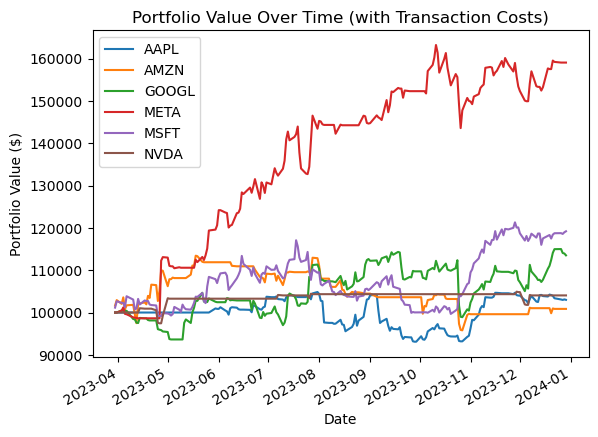

In [18]:
# define transaction cost
transaction_cost = 0.001  # 0.1%

# generate signals
signals = pd.DataFrame(predictions, index=X_test.index, columns=['MSFT', 'NVDA', 'AAPL', 'AMZN', 'META', 'GOOGL'])

# calculate positions
positions = signals.shift(1)

# calculate portfolio returns considering transaction costs
portfolio_returns = positions * returns.loc[X_test.index] - transaction_cost * np.abs(positions.diff())

# calculate cumulative portfolio value
initial_capital = 100000
portfolio_value = (1 + portfolio_returns).cumprod() * initial_capital

total_returns = (portfolio_value.iloc[-1] - initial_capital) / initial_capital
for stock in total_returns.index:
    print(f"Total Returns ({stock}): {total_returns[stock]:.2%}")

# plot portfolio value over time
portfolio_value.plot()
plt.title('Portfolio Value Over Time (with Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()

## Performance Metrics

Sharpe Ratio (AAPL): 0.35
Sharpe Ratio (AMZN): 0.03
Sharpe Ratio (GOOGL): 0.84
Sharpe Ratio (META): 2.40
Sharpe Ratio (MSFT): 1.20
Sharpe Ratio (NVDA): 0.71
Max Drawdown (AAPL): -11.20%
Max Drawdown (AMZN): -15.56%
Max Drawdown (GOOGL): -13.50%
Max Drawdown (META): -12.04%
Max Drawdown (MSFT): -14.88%
Max Drawdown (NVDA): -3.53%


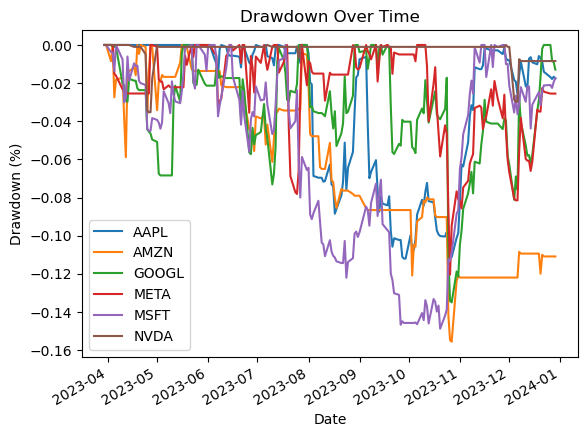

In [19]:
# calculate Sharpe Ratio
portfolio_returns = portfolio_value.pct_change().dropna()
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)

for asset in sharpe_ratio.index:
    print(f"Sharpe Ratio ({asset}): {sharpe_ratio[asset]:.2f}")

# calculate maximum drawdown
rolling_max = portfolio_value.cummax()
drawdown = (portfolio_value - rolling_max) / rolling_max
max_drawdown = drawdown.min()

for asset in max_drawdown.index:
    print(f"Max Drawdown ({asset}): {max_drawdown[asset]:.2%}")

# plot drawdown
drawdown.plot()
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.show()

## Optimization and Hyperparameter Tuning

In [21]:
# define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=10), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


/Users/euge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/euge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      0.87      0.67       104
           1       0.44      0.07      0.11       106
           2       0.63      0.67      0.65       104
           3       0.55      0.49      0.52       104
           4       0.59      0.78      0.67       108
           5       0.54      0.70      0.61       105

   micro avg       0.57      0.60      0.58       631
   macro avg       0.55      0.60      0.54       631
weighted avg       0.55      0.60      0.54       631
 samples avg       0.53      0.52      0.48       631

Total Returns (AAPL): -0.49%
Total Returns (AMZN): -14.56%
Total Returns (GOOGL): 1.58%
Total Returns (META): 46.54%
Total Returns (MSFT): 19.36%
Total Returns (NVDA): -9.01%


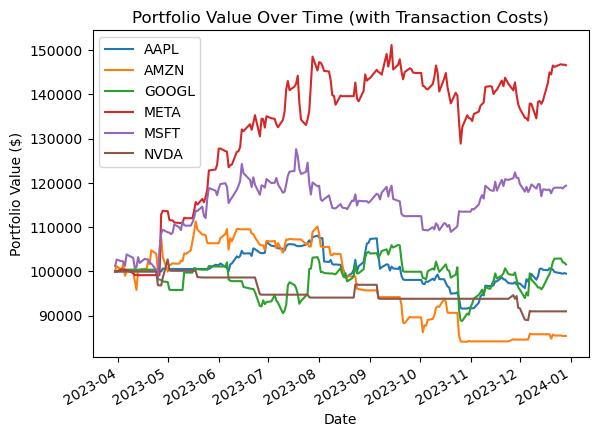

Sharpe Ratio (AAPL): 0.02
Sharpe Ratio (AMZN): -0.87
Sharpe Ratio (GOOGL): 0.21
Sharpe Ratio (META): 1.94
Sharpe Ratio (MSFT): 1.12
Sharpe Ratio (NVDA): -1.06
Max Drawdown (AAPL): -15.23%
Max Drawdown (AMZN): -24.39%
Max Drawdown (GOOGL): -16.19%
Max Drawdown (META): -14.73%
Max Drawdown (MSFT): -14.61%
Max Drawdown (NVDA): -13.33%


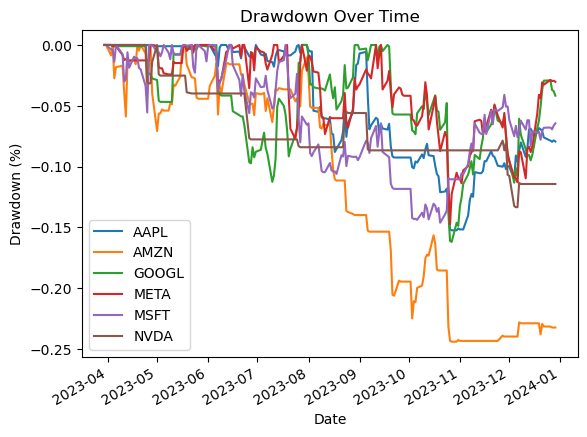

In [25]:
## new model with best parameters
model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, random_state=10)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(classification_report(y_test, predictions))

# define transaction cost
transaction_cost = 0.001  # 0.1%

# generate signals
signals = pd.DataFrame(predictions, index=X_test.index, columns=['MSFT', 'NVDA', 'AAPL', 'AMZN', 'META', 'GOOGL'])

# calculate positions
positions = signals.shift(1)

# calculate portfolio returns considering transaction costs
portfolio_returns = positions * returns.loc[X_test.index] - transaction_cost * np.abs(positions.diff())

# calculate cumulative portfolio value
initial_capital = 100000
portfolio_value = (1 + portfolio_returns).cumprod() * initial_capital

total_returns = (portfolio_value.iloc[-1] - initial_capital) / initial_capital
for stock in total_returns.index:
    print(f"Total Returns ({stock}): {total_returns[stock]:.2%}")

# plot portfolio value over time
portfolio_value.plot()
plt.title('Portfolio Value Over Time (with Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()

# calculate Sharpe Ratio
portfolio_returns = portfolio_value.pct_change().dropna()
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)

for asset in sharpe_ratio.index:
    print(f"Sharpe Ratio ({asset}): {sharpe_ratio[asset]:.2f}")

# calculate maximum drawdown
rolling_max = portfolio_value.cummax()
drawdown = (portfolio_value - rolling_max) / rolling_max
max_drawdown = drawdown.min()

for asset in max_drawdown.index:
    print(f"Max Drawdown ({asset}): {max_drawdown[asset]:.2%}")

# plot drawdown
drawdown.plot()
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.show()

## Risk Management

Total Returns: 61.35%


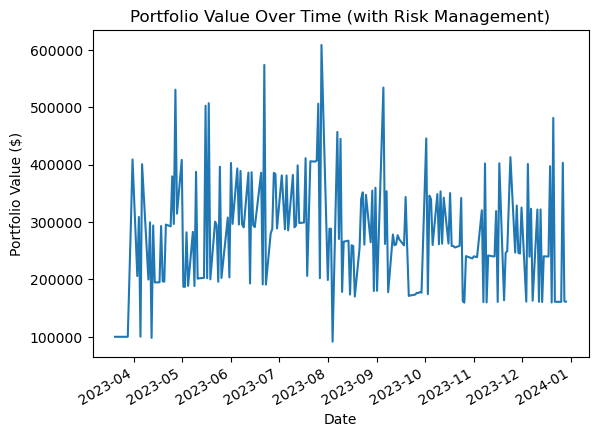

In [26]:
# define stop-loss and take-profit thresholds
stop_loss = 0.02  # 2%
take_profit = 0.05  # 5%

# initialize variables
capital = initial_capital
positions = {ticker: 0 for ticker in tickers}
portfolio_value = []

# reindex signals to match data index
signals = signals.reindex(data.index, method='pad').fillna(0)

for i in range(1, len(signals)):
    current_date = signals.index[i]
    current_prices = data.loc[current_date]
    
    for ticker in tickers:
        if positions[ticker] == 0:  # no current position
            if signals[ticker].iloc[i] == 1:
                positions[ticker] = capital / current_prices[ticker]
                buy_price = current_prices[ticker]
        else:  # current position exists
            if current_prices[ticker] >= buy_price * (1 + take_profit) or current_prices[ticker] <= buy_price * (1 - stop_loss):
                capital = positions[ticker] * current_prices[ticker] - transaction_cost * positions[ticker] * current_prices[ticker]
                positions[ticker] = 0
    
    portfolio_value.append(capital + sum(positions[ticker] * current_prices[ticker] for ticker in tickers))

# convert to series for easier handling
portfolio_value = pd.Series(portfolio_value, index=data.index[1:])

print(f"Total Returns: {(portfolio_value.iloc[-1] - initial_capital) / initial_capital:.2%}")

# plot portfolio value over time with risk management
start_date = '2023-03-20'
portfolio_value[start_date:].plot()
plt.title('Portfolio Value Over Time (with Risk Management)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()